In [1]:
import torch
import torch.nn as nn
import torchaudio
from pathlib import Path
import pandas as pd
import IPython.display as ipd
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz

--2022-05-17 14:19:05--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 172.217.27.48, 2404:6800:4005:808::2010
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|172.217.27.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  7.57MB/s    in 44s     

2022-05-17 14:19:49 (7.61 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]



In [3]:
!tar -xf nsynth-test.jsonwav.tar.gz

In [4]:
class NSynthDataSet:
  def __init__(self, path):
    if isinstance(path, str):
      path = Path(path)
    self.path = path
    json_path = path / "examples.json"
    self.meta = pd.read_json(json_path).to_dict()
    self.file_list = list(self.path.rglob('*.wav'))
    
  def __getitem__(self, idx):
    fn = self.file_list[idx]
    audio, sr = torchaudio.load(fn)
    pitch = self.meta[fn.stem]['pitch']
    pitch_vec = torch.zeros(120)
    pitch_vec[pitch-1] = 1
    return audio, pitch_vec
  
  def __len__(self):
    return len(self.meta.keys())

dataset = NSynthDataSet(Path('nsynth-test'))

In [12]:
df = pd.read_json('nsynth-test/examples.json')
df['bass_synthetic_068-049-025']['pitch']

49

In [17]:
dataset.meta[dataset.file_list[0].stem]

{'qualities': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'pitch': 72,
 'note': 205523,
 'instrument_source_str': 'electronic',
 'velocity': 25,
 'instrument_str': 'keyboard_electronic_098',
 'instrument': 905,
 'sample_rate': 16000,
 'qualities_str': [],
 'instrument_source': 1,
 'note_str': 'keyboard_electronic_098-072-025',
 'instrument_family': 4,
 'instrument_family_str': 'keyboard'}

In [21]:
audio, pitch = dataset[2000]
ipd.Audio(audio, rate=16000)

In [22]:
audio

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [23]:
train_loader = DataLoader(dataset, batch_size=128, num_workers=4, shuffle=True, pin_memory=True)
# test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
batch = next(iter(train_loader))

In [24]:
audio, pitch = batch

audio.shape, pitch.shape

(torch.Size([128, 1, 64000]), torch.Size([128, 120]))

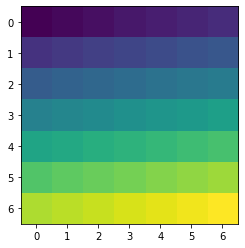

In [27]:
dummy = torch.arange(49).view(1, 7,7).float()

plt.imshow(dummy[0])

In [65]:
kernel_size = 3
padding_size= 2
stride_size = 2
conv_layer = nn.Conv2d(1, 1, kernel_size, padding=padding_size, stride=stride_size)

In [66]:
conv_output = conv_layer(dummy)

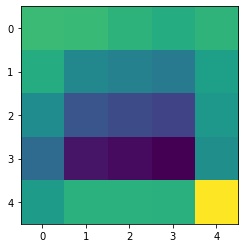

In [67]:
plt.imshow(conv_output[0].detach())

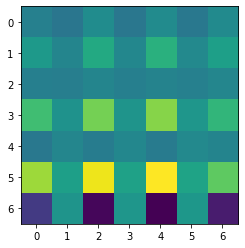

In [74]:
# kernel_size = 3
padding_size= 2
# stride_size = 2

conv_t_layer = nn.ConvTranspose2d(1,1, kernel_size, padding=padding_size, stride=stride_size)
t_output = conv_t_layer(conv_output)

plt.imshow(t_output[0].detach())

In [72]:
conv_t_layer(conv_layer(dummy)).shape, dummy.shape

(torch.Size([1, 7, 7]), torch.Size([1, 7, 7]))

In [ ]:
class SpecModel(nn.Module):
  def __init__(self, n_fft, hop_length):
    super().__init__()
    self.spec_converter = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    self.db_converter = torchaudio.transforms.AmplitudeToDB(stype='power')

  def forward(self, audio_sample):
    spec = self.spec_converter(audio_sample)
    db_spec = self.db_converter(spec)
    return db_spec

class Conv2dNormPool(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()
    
  def forward(self, x):
    x = self.conv(x)
    x = self.batch_norm(x)
    x = self.activation(x)
    return x
  
class Conv2dNormTransposePool(Conv2dNormPool):
  def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
    super().__init__(in_channels, out_channels, kernel_size, padding, stride)
    self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride)

  
class AutoEncoder(nn.Module):
  def __init__(self, n_fft, hop_length, hidden_size=256):
    super().__init__()
    self.spec_model = SpecModel(n_fft, hop_length)
    self.encoder = nn.Sequential()
    self.num_channels = [1] + [hidden_size // 2**i for i in reversed(range(7))]
    for i in range(6):
      self.encoder.add_module(f"conv_norm{i}", Conv2dNormPool(self.num_channels[i], self.num_channels[i+1], (4,4), 1, (2,2) ))
    self.encoder.add_module(f"final_conv",nn.Conv2d(in_channels=self.num_channels[-2], out_channels=self.num_channels[-1], kernel_size=(3,3), padding=1))
    self.final_layer = nn.Linear(hidden_size * 32, hidden_size) 
  
    self.decoder = nn.Sequential(      
        Conv2dNormTransposePool(in_channels=self.num_channels[-1]+120, out_channels=self.num_channels[-2], kernel_size=(8,4), padding=0, stride=(2,2))
    )
    for i in range(5):
      self.decoder.add_module(f"conv_norm{i}", Conv2dNormTransposePool(self.num_channels[-2-i], self.num_channels[-3-i], (4,4), 1, (2,2)))
    self.decoder.add_module("final_module",  nn.ConvTranspose2d(in_channels=self.num_channels[1], out_channels=1, kernel_size=(4,4), padding=1, stride=(2,2)),)

    
  def forward(self, x, pitch):
    spec = self.spec_model(x)
    spec = spec[:,:,:-1] # to match 512
    spec /= 80
    spec = nn.functional.pad(spec, (2,3), value=torch.min(spec))
    out = self.encoder(spec)

    latent = self.final_layer(out.view(out.shape[0], -1))
    latent = torch.cat([latent, pitch], dim=-1)
    latent = latent.view(latent.shape[0], -1, 1, 1)
    recon_spec = self.decoder(latent)
    return recon_spec, spec
  
model = AutoEncoder(1024, 256, 1024)
recon_spec, spec = model(audio, pitch)
recon_spec.shape, spec.shape